# Generating dataset for multimnist and multimnis_cluttered dataset
This notebook shows how to generate the train and test set for the multimnist and multimnist_cluttered tasks

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, datasets
import copy
import os
from tqdm.notebook import tqdm
import numpy as np 
from numpy import random
np.set_printoptions(suppress=True)


def generate_displays(args, train, train_val_split='None'):
    """
    This function generates multi digit mnist displays with different levels of overlap and clutter 
    
    args: arguments generated from args_stru below
    train: if true, download the mnist train dataset, or test set
    train_val_split: 
        - if 'train', use only 90 percent of the mnist training images for creating the training data, 
        - if 'val', use the ramaining 10 percent of the mnist training images for creating the validation data.
        
    General Procedure 
    1) Randomly sample args.num_objects (e.g.,2) images and create one overlapping image (max distance btw centers are 2*args.object_shift_lim)
    : sample more images than needed first, e.g., 4*(args.num_objects) images, in case some objects discarded to avoid having duplicates 
    2) Randomly sample args.clutter_pieces (e.g.,6) images and randomly crop the parts. Add these parts into randomly selected location. 
    
    """
    
    # original mnist download
    im_set = datasets.MNIST(args.data_dir,train=train, download=args.download)
    
    if train_val_split == 'train': # get train split range
        data_range = [0, int(.9*len(im_set))]
    elif train_val_split == 'val': # get val split range
        data_range = [int(.9*len(im_set)), len(im_set)]
    else: # get entire dataset range
        data_range = [0, len(im_set)]


    # sample image indices for creating overlapping objects and clutter pieces
    # e.g., (60000, 50, 14)
    all_pairs = random.choice(range(data_range[0], data_range[1]), 
                              (data_range[1]-data_range[0], args.trials_per_im, 4*args.num_objects+ args.clutter_pieces))

    # sample each object's shift-from-the-center (x/y directions) 
    all_shifts = random.choice(range(-args.object_shift_lim, 1+args.object_shift_lim), 
                               (data_range[1]-data_range[0], args.trials_per_im, 4*args.num_objects, 2))      

    # sample cropping region (upper-left corner coordinates x,y) 
    all_crops = random.choice(range(0, args.obj_dim[0]-args.clutter_dim[0]),
                              (data_range[1]-data_range[0], args.trials_per_im, args.clutter_pieces, 2)) 
    
    # sample each cluttered piece's shift-from-the-center (x/y directions) 
    crop_shifts = random.choice(range(-args.clutter_shift_lim, 1+args.clutter_shift_lim), 
                                (data_range[1]-data_range[0], args.trials_per_im, args.clutter_pieces, 2))
    

    # lists for storing created images and ys
    ims = []
    ys = []
    
    for p in tqdm(range(all_pairs.shape[0])):
        
        for t_per_im in range(args.trials_per_im):

            # the orig image indices for this trial 
            ps =  all_pairs[p][t_per_im]
            
            # the object shifts for this trial  
            locs = all_shifts[p][t_per_im]
            
            # im will keep each object and clutter piece in a different dimension 
            blank = np.zeros((args.num_objects+args.clutter_pieces,args.im_d[0],args.im_d[1]))
            im = copy.deepcopy(blank)
            
            im_center = np.ceil(im.shape[-1]/2)     
            x_center = np.ceil(args.obj_dim[0] / 2) # 14 for mnist 
            
            y = []
            new_o = 0  # keep track of how many objects are added to the display and terminate if hit the limit
            
            for o in range(4*args.num_objects):

                y_ = copy.deepcopy(im_set[ps[o]][1])
                
                # if cat_dup is not allowed, check to see if y_ is already there, if yes, then continue to the next obj
                if not args.cat_dup:
                    if y_ in y:
                        continue 
                        
                # append this y to list          
                y.append(y_)

                # the shifts for this specific object 
                loc = locs[o]
                
                # the image 
                x = copy.deepcopy(np.asarray(im_set[ps[o]][0]))
                
                # find the upper left corners and place the image one the bigger canvas in its dimension 
                corner_row = int(loc[0] + im_center - x_center)
                corner_col = int(loc[1] + im_center - x_center )
                im[new_o,corner_row:corner_row+x.shape[0],corner_col:corner_col+x.shape[1]] = x 
                # alternatvely we can just add them up to not keep everthing separate 
                # im[corner_row:corner_row+x.shape[0],corner_col:corner_col+x.shape[1],1] = \
                #                       im[corner_row:corner_row+x.shape[0],corner_col:corner_col+x.shape[1]] + x
                
                # terminate the loop if we reach the total of number of objects in this trial 
                new_o = new_o + 1
                if args.num_objects == new_o:
                    break
                    

            # turn y one-hot, if cat_dup is allowed, then there will be 2 ones in y_c
            y = np.array(y)
            y_c = np.zeros((y.size, args.n_classes))
            y_c[np.arange(y.size),y] = 1
            #y = np.sum(y_c,axis=0)
    
    
            loc_crop = all_crops[p][t_per_im]
            shift_crop = crop_shifts[p][t_per_im]
            crop_center = 4
            
            for o in range(args.clutter_pieces):  
                # note that the first 4*args.num_objects were reserved for the objects so the clutter pieces are selected after that
                x = np.asarray(im_set[ps[4*args.num_objects+o]][0])
                # crop image
                x = x[loc_crop[o][0]:loc_crop[o][0]+8, loc_crop[o][1]:loc_crop[o][1]+8]
                
                # get location of cropped pieces
                loc = shift_crop[o]
                corner_row = int(loc[0] + im_center - crop_center)
                corner_col = int(loc[1] + im_center - crop_center)
                
                # add cropped pieces to locations 
                im[args.num_objects+o, corner_row:corner_row+x.shape[0], corner_col:corner_col+x.shape[1]] = x
                #im[corner_row:corner_row+x.shape[0],corner_col:corner_col+x.shape[1]] = x # np.expand_dims(x,-1)
#                 im[corner_row:corner_row+x.shape[0],corner_col:corner_col+x.shape[1]] = \
#                                       im[corner_row:corner_row+x.shape[0],corner_col:corner_col+x.shape[1]] + x


            if args.turn_y_onehot:
                ys.append(y_c)
            else:
                ys.append(y)
    
            if args.add_diff_layers:
                im = np.sum(im, axis=0, keepdims=True)
            ims.append(im) #np.expand_dims(im, axis=1))
            
    return ims, ys

## Generate MultiMNIST

In [ ]:
class args_stru:
    def __init__(self):
        
        # dataset info and save directory
        self.data_name = 'mnist'
        self.download = True # If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.
        self.n_classes = 10
        self.obj_dim = (28,28)  # the size of an mnist image
        
        self.data_dir = './data' # root data directory where images are downloaded to.       
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)
            
        self.save_dir = self.data_dir + '/multimnist/' # directory where final multimnist datasets are saved to
        
        # params for multimnist dataset creation 
        self.trials_per_im = 10  # how many new images created for each image in the dataset; 50 is used to generate the dataset in the article
        self.num_objects = 2 # how many objects in each image
        self.cat_dup = False # whether multiple objects could be from the same category 
        self.im_d =(36,36) # size of the resulting image 
        
        self.turn_y_onehot = True # whether to turn the true y one_hot or keep as the category index 
        self.add_diff_layers = True # whether to add different layers of the image and clutter to form a 1 d tensor for the resulting image 
        
        # set overlapping degree 
        self.high_overlap = True # if true, object_shift_lim = 4 was used in the paper, which makes 20-28 pixels overlapped  
        self.object_shift_lim_max = int(self.im_d[0]/2 - np.ceil(self.obj_dim[0] / 2)) # largest possible shift lim
    
        if self.high_overlap: 
            self.object_shift_lim  = 4  # up to how many pixels can each object center shifts from the image center (smaller shift, larger overlap)
        else: 
            # otherwise, the shifts would be as much as allowed from the orig and final image sizes 
            self.object_shift_lim  =  self.object_shift_lim_max
        
        # set clutteredness
        self.clutter_pieces = 0  # how many clutter pieces
        self.clutter_dim = (8,8) # size of the clutter pieces 
        self.clutter_shift_lim = int(self.im_d[0]/2 - np.ceil(self.clutter_dim[0] / 2))   # up to how many pixels can the clutter pieces shift from the center

        
args = args_stru()

print("generate train dataset...")
train_ims, train_ys = generate_displays(args, train=True)  #, train_val_split='none'
tensor_train_ims = torch.Tensor(train_ims)/255 # transform to torch tensor
tensor_train_ims = torch.clip(torch.sum(tensor_train_ims, dim=1, keepdim=True),0, 1)
tensor_train_ys = torch.sum(torch.Tensor(train_ys), dim=1)
#tensor_train_ys = torch.Tensor(train_ys)

# val_ims, val_ys = generate_displays(args, train=True, train_val_split='val')
# tensor_val_ims = torch.Tensor(val_ims)/255 # transform to torch tensor
# tensor_val_ims = torch.clip(torch.sum(tensor_val_ims, dim=1, keepdim=True),0, 1)
# tensor_val_ys = torch.sum(torch.Tensor(val_ys), dim=1)

# tensor_train_ims = torch.cat((tensor_train_ims,tensor_val_ims),dim=0)
# tensor_train_ys = torch.cat((tensor_train_ys,tensor_val_ys),dim=0)

print("generate test dataset...")
test_ims, test_ys = generate_displays(args, train=False)
tensor_test_ims = torch.Tensor(test_ims)/255 # transform to torch tensor
tensor_test_ims = torch.clip(torch.sum(tensor_test_ims, dim=1, keepdim=True),0, 1)
tensor_test_ys = torch.sum(torch.Tensor(test_ys), dim=1)
#tensor_test_ys = torch.Tensor(test_ys)

print(tensor_train_ims.shape)
print(tensor_test_ys.shape)

### visualize data

tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


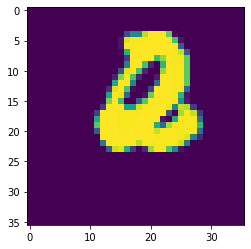

-----------------
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])


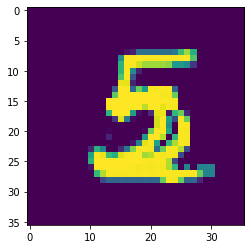

-----------------
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0.])


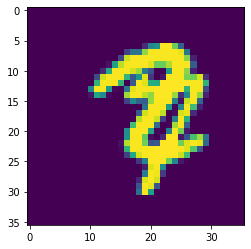

-----------------
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])


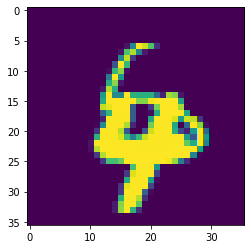

-----------------
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0.])


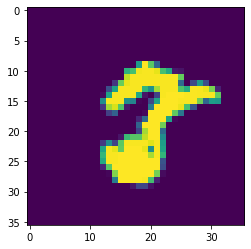

-----------------


In [3]:
for i in range(5):
    plt.imshow(np.squeeze(tensor_train_ims[i]))
    print(tensor_train_ys[i])
    plt.show()
    print('-----------------')

### save as pytorch data file 

In [4]:
if not os.path.isdir(args.save_dir):
    os.makedirs(args.save_dir)

if args.cat_dup:
    DUP = 'dup'
else: DUP = 'nodup'

torch.save((tensor_train_ims, tensor_train_ys), args.save_dir + 
           f'mnist_overlap{args.object_shift_lim}pix_{DUP}_{args.trials_per_im}fold_{args.im_d[0]}_train.pt')
###torch.save((tensor_val_ims, tensor_val_ys), repo_dir+'MNIST_overlap/mnist_overlap4pix_nodup_20fold_36_val.pt')
torch.save((tensor_test_ims, tensor_test_ys), args.save_dir + 
            f'mnist_overlap{args.object_shift_lim}pix_{DUP}_{args.trials_per_im}fold_{args.im_d[0]}_test.pt')

### save as numpy .npz file

In [5]:
if not os.path.isdir(args.save_dir):
    os.makedirs(args.save_dir)

if args.cat_dup:
    DUP = 'dup'
else: DUP = 'nodup'

tensor_train_ims = tensor_train_ims.numpy()
tensor_train_ys = tensor_train_ys.numpy()

tensor_test_ims = tensor_test_ims.numpy()
tensor_test_ys  = tensor_test_ys.numpy()

np.savez(args.save_dir + f'mnist_overlap{args.object_shift_lim}pix_{DUP}_{args.trials_per_im}fold_{args.im_d[0]}_train.npz', \
         tensor_train_ims=tensor_train_ims, tensor_train_ys=tensor_train_ys)

np.savez(args.save_dir +  f'mnist_overlap{args.object_shift_lim}pix_{DUP}_{args.trials_per_im}fold_{args.im_d[0]}_test.npz', \
         tensor_test_ims=tensor_test_ims, tensor_test_ys=tensor_test_ys)

## Generate MultiMNIST_Cluttered

In [9]:
class args_stru:
    def __init__(self):
        
        # dataset info and save directory
        self.data_name = 'mnist'
        self.download = True # If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.
        self.n_classes = 10
        self.obj_dim = (28,28)  # the size of an mnist image
        
        self.data_dir = './data' # root data directory where images are downloaded to.       
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)
            
        self.save_dir = self.data_dir + '/multimnist/' # directory where final multimnist datasets are saved to
        
        # params for multimnist dataset creation 
        self.trials_per_im = 1  # how many new images created for each image in the dataset; 3 is used to generate the dataset in the article
        self.num_objects = 2 # how many objects in each image
        self.cat_dup = True # whether multiple objects could be from the same category 
        self.im_d =(100,100) # size of the resulting image 
        
        self.turn_y_onehot = True # whether to turn the true y one_hot or keep as the category index 
        self.add_diff_layers = True # whether to add different layers of the image and clutter to form a 1 d tensor for the resulting image 
        
        # set overlapping degree 
        self.high_overlap = False # if true, object_shift_lim = 4 was used in the paper, which makes 20-28 pixels overlapped  
        self.object_shift_lim_max = int(self.im_d[0]/2 - np.ceil(self.obj_dim[0] / 2)) # largest possible shift lim
    
        if self.high_overlap: 
            self.object_shift_lim  = 4  # up to how many pixels can each object center shifts from the image center (smaller shift, larger overlap)
        else: 
            # otherwise, the shifts would be as much as allowed from the orig and final image sizes 
            self.object_shift_lim  =  self.object_shift_lim_max
        
        # set clutteredness
        self.clutter_pieces = 6  # how many clutter pieces
        self.clutter_dim = (8,8) # size of the clutter pieces 
        self.clutter_shift_lim = int(self.im_d[0]/2 - np.ceil(self.clutter_dim[0] / 2))   # up to how many pixels can the clutter pieces shift from the center

    
args = args_stru()



train_ims, train_ys = generate_displays(args, train=True, train_val_split='train')  #
tensor_train_ims = torch.Tensor(train_ims)/255 # transform to torch tensor
tensor_train_ims = torch.clip(torch.sum(tensor_train_ims, dim=1, keepdim=True),0, 1)
tensor_train_ys = torch.sum(torch.Tensor(train_ys), dim=1)
#tensor_train_ys = torch.Tensor(train_ys)

val_ims, val_ys = generate_displays(args, train=True, train_val_split='val')
tensor_val_ims = torch.Tensor(val_ims)/255 # transform to torch tensor
tensor_val_ims = torch.clip(torch.sum(tensor_val_ims, dim=1, keepdim=True),0, 1)
tensor_val_ys = torch.sum(torch.Tensor(val_ys), dim=1)

tensor_train_ims = torch.cat((tensor_train_ims,tensor_val_ims),dim=0)
tensor_train_ys = torch.cat((tensor_train_ys,tensor_val_ys),dim=0)


test_ims, test_ys = generate_displays(args, train=False)
tensor_test_ims = torch.Tensor(test_ims)/255 # transform to torch tensor
tensor_test_ims = torch.clip(torch.sum(tensor_test_ims, dim=1, keepdim=True),0, 1)
tensor_test_ys = torch.sum(torch.Tensor(test_ys), dim=1)
#tensor_test_ys = torch.Tensor(test_ys)


print(tensor_train_ims.shape)
print(tensor_test_ys.shape)

  0%|          | 0/54000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([180000, 1, 100, 100])
torch.Size([30000, 10])


### visualize data

tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])


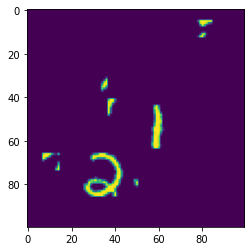

-----------------
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0.])


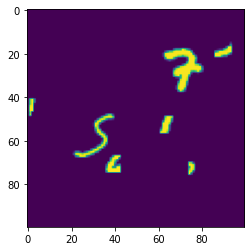

-----------------
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1.])


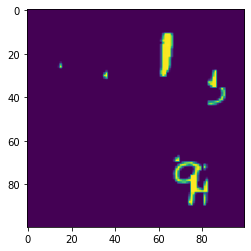

-----------------
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


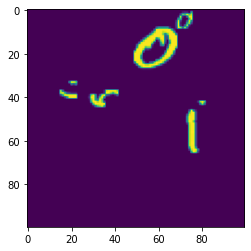

-----------------
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0.])


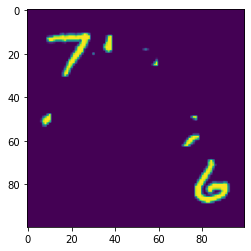

-----------------


In [10]:
for i in range(5):
    plt.imshow(np.squeeze(tensor_train_ims[i]))
    print(tensor_train_ys[i])
    plt.show()
    print('-----------------')

### save as pytorch data file 

In [11]:
if not os.path.isdir(args.save_dir):
    os.makedirs(args.save_dir)

torch.save((tensor_train_ims, tensor_train_ys), args.save_dir + 
           f'mnist_cluttered{args.num_objects}o{args.clutter_pieces}c_{args.trials_per_im}fold_{args.im_d[0]}_trainval.pt')
torch.save((tensor_test_ims, tensor_test_ys), args.save_dir + 
           f'mnist_cluttered{args.num_objects}o{args.clutter_pieces}c_{args.trials_per_im}fold_{args.im_d[0]}_test.pt')

## Generate Multi-SVHN

In [1]:
# Helper functions to process svhn data
# Codes mainly adapted from https://github.com/pitsios-s/SVHN-Thesis/blob/master/src/multi_digit/svhn.py
# https://github.com/pitsios-s/SVHN
# https://github.com/Alikerin/Pytorch-1.0-Implementation-of-Google-Street-View-House-Numbers-SVHN-classifier


%matplotlib inline 
import matplotlib.pyplot as plt

import h5py
import os
import numpy as np
import PIL.Image as Image
import random


class SVHNMulti:
    """ This class contains all the necessary functionality to Load, Process and Save the SVHN multi digit images """

    def __init__(self, output_dir, max_labels=5, normalize=True, gray=False, tight_crop=True):
        """ Default constructor
        Args:
            output_dir: The directory the processed data will be stored
            max_labels: The maximum number of digit length that we will allow
            normalize: Image normalization flag
            gray: Image gray scaling flag
        """
        self.PIXEL_DEPTH = 255
        self.NUM_LABELS = 11
        self.OUT_HEIGHT = 64
        self.OUT_WIDTH = 64
        self.NUM_CHANNELS = 3
        self.MAX_LABELS = max_labels
        self.output_dir = output_dir
        self.file = None
        self.digit_struct_name = None
        self.digit_struct_bbox = None
        self.normalize = normalize
        self.gray = gray
        self.tight_crop = tight_crop

    def get_image_name(self, n):
        """Returns the current image's name
        Args:
            n: The index of the image

        Returns:
            The name of the n-th image
        """
        name = ''.join([chr(c[0]) for c in self.file[self.digit_struct_name[n][0]]])
        return name

    def bounding_box_helper(self, attr):
        """Extracts and returns the value of a specific attribute of the bounding box structure

        Args:
            attr: The attribute to extract its value
        Returns:
            The value of the attribute
        """
        if len(attr) > 1:
            attr = [self.file[attr[j].item()][0][0] for j in range(len(attr))]
        else:
            attr = [attr[0][0]]
        return attr

    def get_bounding_box(self, n):
        """Extracts and returns the bounding box information, regarding the n-th image

        Args:
            n: The index of the image

        Returns:
            Bounding box information about the n-th image
        """
        bbox = {}
        bb = self.digit_struct_bbox[n].item()

        bbox['label'] = self.bounding_box_helper(self.file[bb]["label"])
        bbox['top'] = self.bounding_box_helper(self.file[bb]["top"])
        bbox['left'] = self.bounding_box_helper(self.file[bb]["left"])
        bbox['height'] = self.bounding_box_helper(self.file[bb]["height"])
        bbox['width'] = self.bounding_box_helper(self.file[bb]["width"])

        return bbox

    def get_digit_structure(self, n):
        """Creates and returns the whole structure of the image, including the name, based on bounding boxes

        Args:
            n: The index of the image under consideration

        Returns:
            The image's structure
        """
        structure = self.get_bounding_box(n)
        structure['name'] = self.get_image_name(n)
        return structure

    def get_all_images_and_digit_structures(self):
        """Loops through every image and returns a large array containing the structure of each one"""
        structs = []
        for i in range(len(self.digit_struct_name)):
            structure = self.get_digit_structure(i)
            if len(structure["label"]) <= self.MAX_LABELS:
                structs.append(structure)
        return structs

    def save_data(self, data, labels, name):
        """Saves image data and labels in hdf5 format

        Args:
            data: The image data array
            labels: The labels of the images
            name: The name of the file to created
        """
        h5f = h5py.File(os.path.join(self.output_dir, name + ".h5"), "w")
        h5f.create_dataset(name + "_dataset", data=data)
        h5f.create_dataset(name + "_labels", data=labels)

    def load_data(self, name):
        """Loads an hdf5 file that contains the image data and labels

        Args:
            name: The name of the file to be loaded

        Returns:
            The data and labels arrays
        """
        h5f = h5py.File(os.path.join(self.output_dir, name + ".h5"), "r")
        data = h5f[name + "_dataset"][:]
        labels = h5f[name + "_labels"][:]

        return data, labels

    def read_digit_structure(self, data_dir):
        """Loads the digit structure file, stores the image name and bounding boxes details and returns an array
        containing the image name, as well as arrays containing the information about bounding boxes

        Args:
            data_dir: The directory that contains the digit structure file
        Returns:
            All the information from the structure file
        """
        struct_file = data_dir + "/digitStruct.mat"
        self.file = h5py.File(struct_file, 'r')
        self.digit_struct_name = self.file['digitStruct']['name']
        self.digit_struct_bbox = self.file['digitStruct']['bbox']
        structs = self.get_all_images_and_digit_structures()

        return structs

    def process_file(self, data_dir):
        """Processes all images one by one and returns them, together with their labels

        Args:
            data_dir: The directory that contains the images and the structure file

        Returns:
            The processed images and their labels
        """
        if self.gray:
            self.NUM_CHANNELS = 1

        structs = self.read_digit_structure(data_dir)
        data_count = len(structs)
        
        print(data_count)

        image_data = np.zeros((data_count, self.OUT_HEIGHT, self.OUT_WIDTH, self.NUM_CHANNELS), dtype=np.float32)
        labels = np.zeros((data_count, self.MAX_LABELS, self.NUM_LABELS), dtype=np.int32)

        ind = 0
        for i in range(data_count):
            lbls = structs[i]['label']
            file_name = os.path.join(data_dir, structs[i]['name'])
            top = structs[i]['top']
            left = structs[i]['left']
            height = structs[i]['height']
            width = structs[i]['width']

            lbls_img = self.create_label_array(lbls)
#             print('lbls_img')
#             print(lbls_img)
#             print(lbls_img.shape)
#             print(lbls_img[0])
            
            image = Image.open(file_name)

#            print('image.size')
            img_size = image.size
#            print(img_size)

            s_side = min(img_size)
            l_side = max(img_size)
        
#             if (np.max(np.sum(lbls_img[:,:10], axis=0)) == 1): # & (l_side>50) & (s_side>50):
            
            image_array = self.create_image_array(image, top, left, height, width)

            if np.max(image_array) > 0:

                image_data[ind] = image_array
                labels[ind] = lbls_img  #[0] + lbls_img[1]

                #print(ind)
                ind = ind + 1
                

        return image_data, labels, ind

    def create_label_array(self, labels):
        """Creates and returns an array of one-hot-encoded arrays, one for every digit in of the input label

        Args:
            labels: The labels of the current image, i.e a number with 1 to 5 digits

        Returns:
            An array of one-hot-encoded representations, for every digit in the input label
        """
        num_digits = len(labels)
        labels_array = np.ones([self.MAX_LABELS], dtype=np.int32) * 10
        one_hot_labels = np.zeros((self.MAX_LABELS, self.NUM_LABELS), dtype=np.int32)

        for n in range(num_digits):
            if labels[n] == 10:
                labels[n] = 0
            labels_array[n] = labels[n]

        for n in range(len(labels_array)):
            one_hot_labels[n] = self.one_hot_encode(labels_array[n])

        return one_hot_labels

    def one_hot_encode(self, number):
        """ Creates and returns a hot-hot-encoding representation of a given number
        Args:
            number: The number to be encoded
        Returns:
            The one-hot representation of the given number as a numpy array
        """
        one_hot = np.zeros(shape=self.NUM_LABELS, dtype=np.int32)
        one_hot[number] = 1

        return one_hot

    def create_image_array(self, image, top, left, height, width):
        """Crops an image so that it will contain only the portion with the digits of interest

        Args:
            file_name: The name of the image to be processed
            top: The Y-coordinate of the top left point of every digit's bounding box
            left: The X-coordinate of the top left point of every digit's bounding box
            height: The height of every digit's bounding box
            width: The width of every digit's bounding box

        Returns:
            A numpy representation of the processed image
        """

        # Load image
        #image = Image.open(file_name)
        
#         desired_size = 100
#         old_size = image.size
        
#         ratio = float(desired_size)/max(old_size)
#         new_size = tuple([int(x*ratio) for x in old_size])
        
#         image = image.resize(new_size, Image.ANTIALIAS)
        
#         new_im = Image.new("RGB", (desired_size, desired_size))
#         new_im.paste(image, ((desired_size-new_size[0])//2,
#                     (desired_size-new_size[1])//2))

        image_array = np.zeros_like(image)
        
        #print('image.size')
        img_size = image.size
        #print(img_size)
        
        s_side = min(img_size)
        l_side = max(img_size)
        
        s_ind = img_size.index(s_side)
        l_ind = img_size.index(l_side)
         
        
        # Find the smallest Y-coordinate among every digit's bounding box
        image_top = np.amin(top)

        # Find the smallest X-coordinate among every digit's bounding box
        image_left = np.amin(left)
        
        image_height = np.amax(top) + height[np.argmax(top)] - image_top
        image_width = np.amax(left) + width[np.argmax(left)] - image_left

        
        
        if self.tight_crop:
            # Find the smallest possible bounding box that will fit all the digits an once, and expand it by 20%
            box_left = np.floor(image_left - 0.1 * image_width)
            box_top = np.floor(image_top - 0.1 * image_height)
            box_right = np.amin([np.ceil(box_left + 1.2 * image_width), image.size[0]])
            box_bottom = np.amin([np.ceil(image_top + 1.2 * image_height), image.size[1]])
            
            # Crop image based on the unified bounding box and scale it to a smaller size
            image = image.crop((box_left, box_top, box_right, box_bottom)).\
                resize([self.OUT_HEIGHT, self.OUT_WIDTH], Image.ANTIALIAS)
        
            
            
        else : # if not self.tight_crop
            area_bbb = image_height * image_width    # area of the bigger bouding box 
            dim_bbb = [image_width, image_height]

            area_crop = s_side * s_side

            # how much can the final crop move along the longer dimension of the original iamge
            jitter_max = (s_side - dim_bbb[l_ind])

            if (jitter_max > 1):

        #                 # Find the smallest possible bounding box that will fit all the digits an once, and expand it by 20%
        #         box_left = np.floor(image_left - 0.1 * image_width)
        #         box_top = np.floor(image_top - 0.1 * image_height)
        #         box_right = np.amin([np.ceil(box_left + 1.2 * image_width), image.size[0]])
        #         box_bottom = np.amin([np.ceil(image_top + 1.2 * image_height), image.size[1]])

                if s_ind == 0: #the short side is the width  - jitter top - down 

                    # in order for the crop not to go outside the image bounds 
                    rand_lowerb = max (((image_top + s_side) - l_side) / jitter_max, 0)
                    rand_upperb = min(image_top/jitter_max, 1)



                    jitter = random.uniform(rand_lowerb, rand_upperb) * jitter_max
                    box_left = 0
                    box_top =  np.floor(image_top - jitter)
                    box_right = s_side 
                    box_bottom = np.ceil(box_top + s_side)

                else:  #the short side is the height   jitter is left - right 

                    # in order for the crop not to go outside the image bounds 
                    rand_lowerb = max (((image_left + s_side) - l_side) / jitter_max, 0)
                    rand_upperb = min(image_left/jitter_max, 1)

                    jitter = random.uniform(rand_lowerb, rand_upperb) * jitter_max
                    box_left = np.floor(image_left - jitter)
                    box_top = 0
                    box_right = np.ceil(box_left + s_side)
                    box_bottom = s_side
                    
                # Crop image based on the unified bounding box and scale it to a smaller size
                image = image.crop((box_left, box_top, box_right, box_bottom)).\
                    resize([self.OUT_HEIGHT, self.OUT_WIDTH], Image.ANTIALIAS)

            else:  # (jitter_max < 1) In this  case no cropping is necessary 
                image = image.resize([self.OUT_HEIGHT, self.OUT_WIDTH], Image.ANTIALIAS)

        
#         print('\n bbb corners')
#         print([box_left, box_top, box_right, box_bottom])


#         plt.imshow(image)
#         plt.show()
        
        # Convert image to numpy array
        image_array = np.array(image)

        # Normalize if necessary
        if self.normalize:
            image_array = (255 - image_array) * 1.0 / 255.0
            #image_array -= np.mean(image_array, axis=0)
        
        # Convert to gray scale if necessary
        if self.gray:
            image_array = np.expand_dims(np.dot(image_array, [0.2989, 0.5870, 0.1140]), axis=2)

        return image_array


PATH_SAVE = "./data/svhn-data/multi/"
svhn = SVHNMulti(PATH_SAVE, normalize=True, gray=True, tight_crop=True)  # , max_labels=3


# f = h5py.File("./svhn-data/multi/train.h5", 'r')
# for key in f.keys():
#     print(key)

In [ ]:
######################################
# download original files and unzip
######################################
# http://ufldl.stanford.edu/housenumbers/
# Format 1: Full Numbers: train.tar.gz, test.tar.gz , extra.tar.gz (Note: for non-commercial use only)

DOWNLOAD = False
if DOWNLOAD:
    def download_from_url(url, savedir, filename, overwrite=False):
        import os
        from urllib.request import urlretrieve

        if not os.path.exists(savedir):
            os.mkdir(savedir)
        if not os.path.exists(savedir+filename) or overwrite:
            print(f'downloading file from {url}...')
            urlretrieve(url, savedir+filename)
            print(f'file saved to {savedir+filename}')
        else: print('file already exist, set overwrite =True for download')

    def unzip(fname, save_dir):
        import tarfile
        if fname.endswith("tar.gz"):
            print(f'extracting {fname}...')
            tar = tarfile.open(fname, "r:gz")
            tar.extractall(save_dir)
            tar.close()
            print(f'saved under {save_dir}')
        elif fname.endswith("tar"):
            print(f'extracting {fname}...')
            tar = tarfile.open(fname, "r:")
            tar.extractall(save_dir)
            tar.close()
            print(f'saved under {save_dir}')

    url = 'http://ufldl.stanford.edu/housenumbers/train.tar.gz'
    savedir = './data/svhn-data/'
    filename = 'train.tar.gz'
    download_from_url(url, savedir, filename)
    unzip(savedir+filename, savedir)

    url = 'http://ufldl.stanford.edu/housenumbers/test.tar.gz'
    savedir = './data/svhn-data/'
    filename = 'test.tar.gz'
    download_from_url(url, savedir, filename)
    unzip(savedir+filename, savedir)

    url = 'http://ufldl.stanford.edu/housenumbers/extra.tar.gz'
    savedir = './data/svhn-data/'
    filename = 'extra.tar.gz'
    download_from_url(url, savedir, filename)
    unzip(savedir+filename, savedir)

In [2]:
#######################
# processing dataset
#######################

import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import torch
import csv
from torch.utils.data.dataset import random_split

# Original Dataset Path
data_dir_train = './data/svhn-data/train/'
data_dir_test = './data/svhn-data/test/'
data_dir_extra = './data/svhn-data/extra/'


# Train dataset
train_ims, train_ys, ind = svhn.process_file(data_dir_train)
#svhn.save_data(train_data, train_labels, "train")
tensor_train_ims = torch.Tensor(train_ims[:ind]) 
tensor_train_ims = torch.movedim(tensor_train_ims, -1, 1)
tensor_train_ys = torch.Tensor(train_ys[:ind])
#tensor_train_ys = torch.sum(tensor_train_ys, 1)[:,:10]

print(ind) # 33401

# Test dataset
test_ims, test_ys, ind = svhn.process_file(data_dir_test)
# svhn.save_data(test_data, test_labels, "test")
tensor_test_ims = torch.Tensor(test_ims[:ind]) 
tensor_test_ims = torch.movedim(tensor_test_ims, -1, 1)
tensor_test_ys = torch.Tensor(test_ys[:ind])
#tensor_test_ys = torch.sum(tensor_test_ys, 1)[:,:10]

print(ind) # 13068

# Extra dataset
extra_ims, extra_ys, ind = svhn.process_file(data_dir_extra)
#svhn.save_data(extra_data, extra_labels, "extra")
tensor_extra_ims = torch.Tensor(extra_ims[:ind]) 
tensor_extra_ims = torch.movedim(tensor_extra_ims, -1, 1)
tensor_extra_ys = torch.Tensor(extra_ys[:ind])
#tensor_extra_ys = torch.sum(tensor_extra_ys, 1)[:,:10]

print(ind) # 202353

# save the original train, test, and extra images. 
# torch.save((tensor_train_ims, tensor_train_ys, tensor_test_ims, tensor_test_ys, tensor_extra_ims, tensor_extra_ys), '../data/svhn-data/svhn_raw.pt')
# load the data from saved files
# tensor_train_ims, tensor_train_ys, tensor_test_ims, tensor_test_ys, tensor_extra_ims, tensor_extra_ys = torch.load('../data/svhn-data/svhn_raw.pt')

33401
33401
13068
13068
202353
202353


In [3]:
#############################################
# add background class for non digit classes
#############################################
def add_classes(tensor_ys): 
#added_classes.shape

    added_classes = torch.zeros((len(tensor_ys), 5, 4))

    for i in range(len(tensor_ys)):
        if torch.sum(tensor_ys[i,:,:10]) == 1:
            added_classes[i,0,:] = torch.tensor([1, 1, 1, 1])
        elif torch.sum(tensor_ys[i,:,:10]) == 2:
            added_classes[i,0,:] = torch.tensor([1, 1, 1, 0])
        elif torch.sum(tensor_ys[i,:,:10]) == 3:
            added_classes[i,0,:] = torch.tensor([1, 1, 0, 0])
        elif torch.sum(tensor_ys[i,:,:10]) == 4:
            added_classes[i,0,:] = torch.tensor([1, 0, 0, 0])
        elif torch.sum(tensor_ys[i,:,:10]) == 5:
            added_classes[i,0,:] = torch.tensor([0, 0, 0, 0])
            
    return torch.cat((tensor_ys[:,:,:10],added_classes), dim=2)       


tensor_train_ims = torch.cat((tensor_extra_ims, tensor_train_ims), dim=0)
tensor_train_ys = torch.cat((tensor_extra_ys, tensor_train_ys), dim=0)

tensor_train_ys = add_classes(tensor_train_ys)
tensor_test_ys = add_classes(tensor_test_ys)

In [8]:
#####################
# shuffle dataset
####################
idx = np.random.permutation(len(tensor_train_ims))
tensor_train_ims, tensor_train_ys= tensor_train_ims[idx], tensor_train_ys[idx]

idx = np.random.permutation(len(tensor_test_ims))
tensor_test_ims, tensor_test_ys= tensor_test_ims[idx], tensor_test_ys[idx]

In [11]:
###################################
# save the train and test datasets
###################################
SAVE = True
if SAVE:    
    torch.save((tensor_train_ims, tensor_train_ys), './data/svhn-data/multisvhn_train_14classes.pt')
    torch.save((tensor_test_ims, tensor_test_ys), './data/svhn-data/multisvhn_test_14classes.pt')

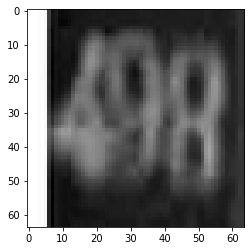

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


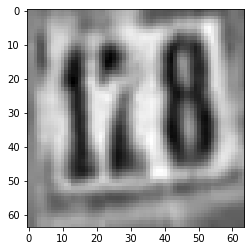

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


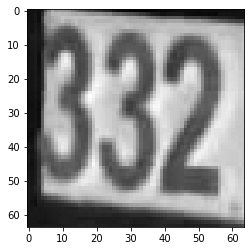

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


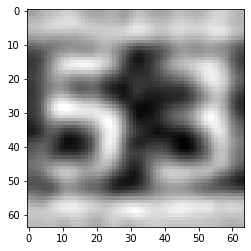

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


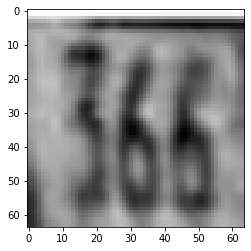

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


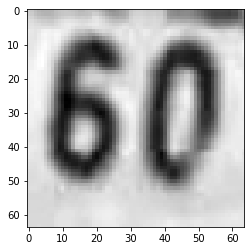

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


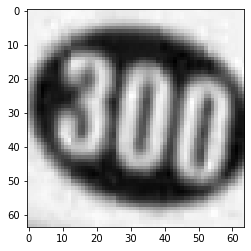

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


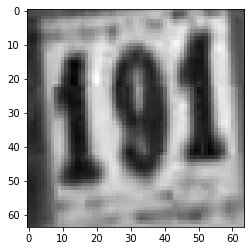

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


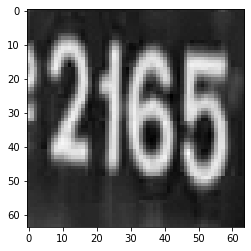

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


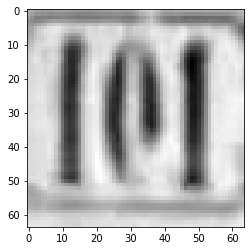

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [12]:
##################################
# Visualize
##################################
%matplotlib inline 
import matplotlib.pyplot as plt

for i in range(10):
    plt.imshow(tensor_train_ims[i, 0], cmap="gray" ) #  np.concatenate((train_ims, extra_data)
    plt.show()
    print(tensor_train_ys[i])

In [14]:
tensor_train_ys.shape #torch.Size([235754, 5, 14])

torch.Size([235754, 5, 14])